In [40]:
import pandas as pd

### 목표
- 문제 정의
- 500명의 키와 몸무게 그리고 비만도를 이용해서 비만을 판단하는 모델을 만들어보자
- 머신러닝 분석과정을 이해해보자


In [41]:
# 필요한 도구를 불러오자!
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier # knn분류모델
from sklearn.metrics import accuracy_score  # 정확도 평가도구


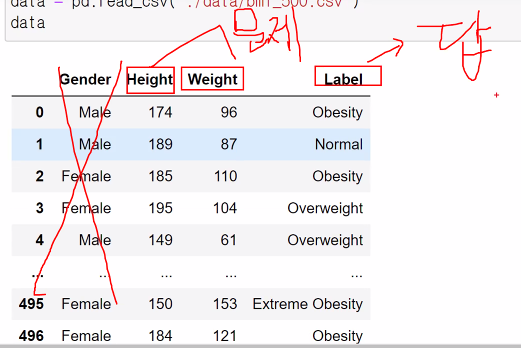

In [42]:
bmi_data = pd.read_csv('./data/bmi_500.csv')
bmi_data

,Gender,Height,Weight,Label
0,Male,174,96,Obesity
1,Male,189,87,Normal
2,Female,185,110,Obesity
3,Female,195,104,Overweight
4,Male,149,61,Overweight
...,...,...,...,...
495,Female,150,153,Extreme Obesity
496,Female,184,121,Obesity
497,Female,141,136,Extreme Obesity
498,Male,150,95,Extreme Obesity


In [43]:
# 데이터 프레임의 정보를 확인
# info()
bmi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Gender  500 non-null    object
 1   Height  500 non-null    int64 
 2   Weight  500 non-null    int64 
 3   Label   500 non-null    object
dtypes: int64(2), object(2)
memory usage: 15.8+ KB


- 전처리 : 학습용으로 제공된 데이터 ->이미 깔끔하게 전처리가 되어있었다!

- 탐색적 데이터 분석(EDA) : 기술통계량 확인, 상관관계 확인(데이터간의 관계성이 있는지), 그래프 시각화(눈으로 보기 편하게)

In [44]:
# 기술통계 확인
bmi_data.describe()

,Height,Weight
count,500.000000,500.000000
mean,169.944000,106.000000
std,16.375261,32.382607
min,140.000000,50.000000
25%,156.000000,80.000000
50%,170.500000,106.000000
75%,184.000000,136.000000
max,199.000000,160.000000


2023_04_10

In [45]:
# 답 데이터 살펴보기
# 답레이블 중복없이 확인해보기
data2 = bmi_data.set_index('Label')  # 원래 컬럼을 인덱스로 보내준것임
data2.index.unique()  # 인덱스에 접근 + 독립적인 값 찾기


# data2.index.unique()했더니 나온 값
# 'Extreme Obesity' :고도비만
# 'Obesity' : 비만
# 'Overweight' : 과체중
# 'Normal' : 보통 
# 'Weak' : 저체중, 
# 'Extremely Weak' : 극심한 저체중
# 클래스가 총 6개임!

Index(['Obesity', 'Normal', 'Overweight', 'Extreme Obesity', 'Weak',
       'Extremely Weak'],
      dtype='object', name='Label')

In [46]:
# 클래스별로 몇개씩 들어있을까?
data2.index.value_counts()

# 머신러닝 학습시 답 레이블 균형을 맞춰주는 것이 학습에 도움이 됨
# 여기는 고도비만, 비만등이 좀 많이 나와있음(이상치 걱정을 해야함!)

Extreme Obesity    198
Obesity            130
Normal              69
Overweight          68
Weak                22
Extremely Weak      13
Name: Label, dtype: int64

In [47]:
# 시각화
# X축 키, Y축 몸무게, 산점도(점 찍어서 분포 확인하는 그래프) Label
# Extreme Obesity만 이용해서 그릴꺼다.
# 행(index, 문자열) 값에 쉽게 접근하게 하는 인덱서 => loc
d = data2.loc['Extreme Obesity']
d

,Gender,Height,Weight
Label,,,
Extreme Obesity,Male,147,92
Extreme Obesity,Male,154,111
Extreme Obesity,Female,153,107
Extreme Obesity,Female,157,110
Extreme Obesity,Male,140,129
...,...,...,...
Extreme Obesity,Male,152,98
Extreme Obesity,Female,150,153
Extreme Obesity,Female,141,136


In [48]:
import matplotlib.pyplot as plt

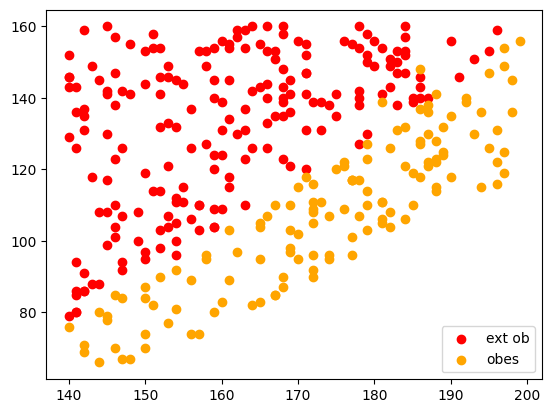

In [49]:
# Extreme Obesity(빨간색)
plt.scatter(d['Height'], d['Weight'],c = 'red', label = 'ext ob')

# Obesity(주황색)
d = data2.loc['Obesity']
plt.scatter(d['Height'], d['Weight'],c = 'orange', label = 'obes')
plt.legend() # 범례표시(출력)
plt.show()

# 이렇게 여러번 반복되면 함수를 실행해야겠다고 생각하는게 좋음!

In [50]:
# 그래프 그리는 함수 생성(정의)
def bmi_draw(label,color) : 
    d = data2.loc[label]
    plt.scatter(d['Height'], d['Weight'],c = color, label = label)


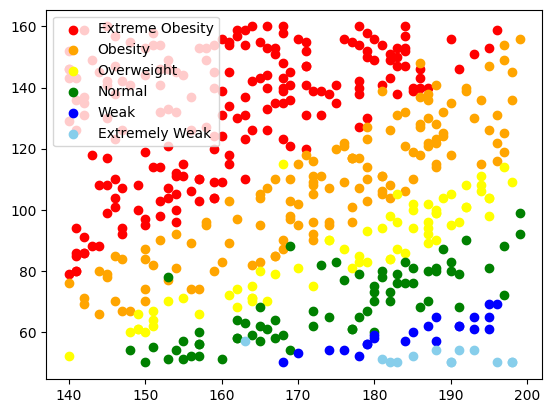

In [51]:
# 클래스 별로 실행하면서, 하나의 도화지에 모든 점을 그려보기(호출)
bmi_draw('Extreme Obesity' , 'red')
bmi_draw('Obesity' , 'orange')
bmi_draw('Overweight' , 'yellow')
bmi_draw('Normal' , 'green')
bmi_draw('Weak' , 'blue')
bmi_draw('Extremely Weak' , 'skyblue')
plt.legend() # 범례표시(출력)
plt.show()


이 앞에서한건 데이터 확인 작업이였음! 

-모델링시작

In [52]:
# 추후에 더 배우게 될 knn모델 불러오기
# 정확도 평가하는 함수(기능)불러오기
# 아까 위에서 부르긴했는데 그냥 불러주기 또
from sklearn.neighbors import KNeighborsClassifier # 분류모델
from sklearn.metrics import accuracy_score # 정확도를 평가해줌

In [53]:
# 지도학습 : 문제와 답
# 머신러닝 모델 : 학습 -> 평가 및 예측
# 학습용 데이터셋(문제, 답)
# 테스트용 데이터셋(문제, 답)

# train 은 7정도 test는 3정도의 비율로 사용이 된다
# 통상적으로 7 : 3의 비율로 분리한다.
# 8 : 2 / 7.5 : 2.5도 있음

# 행 0 : ~350 --> 트레인용이 되는 것임 키 + 몸무게 열
# 행 : 350~ --> 테스트용이 되는 것이다. 
'''
X_train = # 훈련용 문제 0~ 350 행 , 키 + 몸무게 열
y_train = # 훈련용 답 0~ 350 행, Label 열

X_test = # 테스트용 문제  350~ 행 , 키 + 몸무게 열
y_test = # 테스트용 답 350 ~ 행 , Label 열
'''

'\nX_train = # 훈련용 문제\ny_train = # 훈련용 답 \n\nX_test = # 테스트용 문제\ny_test = # 테스트용 답\n'

In [63]:
X_train = bmi_data.iloc[ : 350, 1:3 ]
y_train = bmi_data.iloc[ : 350 , 3 ]

X_test = bmi_data.iloc[ 350 : , 1:3 ]
y_test = bmi_data.iloc[ 350 : , 3 ]

In [55]:

bmi_data

,Gender,Height,Weight,Label
0,Male,174,96,Obesity
1,Male,189,87,Normal
2,Female,185,110,Obesity
3,Female,195,104,Overweight
4,Male,149,61,Overweight
...,...,...,...,...
495,Female,150,153,Extreme Obesity
496,Female,184,121,Obesity
497,Female,141,136,Extreme Obesity
498,Male,150,95,Extreme Obesity


In [68]:
print('훈련용 문제:', X_train.shape)
print('훈련용 답:',y_train.shape)
print('테스트용 문제:',X_test.shape)
print('테스트용 답:',y_test.shape)

훈련용 문제: (350, 2)
훈련용 답: (350,)
테스트용 문제: (150, 2)
테스트용 답: (150,)


In [69]:
# 모델 생성
# 끼리끼리, 가장 가까운 친구보면서 test데이터 예측 하는 모델
# 비슷한 사람끼리 만나지 않을까? -> 이런식으로 모델도 예측하는 것
knn_model = KNeighborsClassifier()  # 이웃 5개 확인하는 상황

In [71]:
# 모델 학습
# fit : 맞추다
# 데이터에 맞춰서 학습한다! -> fit
# 데이터가 중요하다!
# knn_model.fit(훈련용 문제, 훈련답)
knn_model.fit(X_train,y_train)

KNeighborsClassifier()

In [76]:
# 예측
# predict : 예측하다.
# knn_model.predict(테스트 문제)
knn_pre = knn_model.predict(X_test)

In [77]:
# 평가
# 정확도 평가지표
# accuracy_score(실제값,예측값)
accuracy_score( y_test , knn_pre)  # 90% 맞은 상황!

0.9066666666666666

In [ ]:
# + 모델 저장, 실제 서비스 단에서 사용 